In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import importlib
warnings.filterwarnings('ignore')

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

# #Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers

In [168]:
from analysis.data.dataframe_creation import pipeline
# Date range
sd = '2016-01-01'
ed = '2024-01-01'
# snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
# data_tab = pd.read_html(snp500url)

# tickers = data_tab[0][1:]['Symbol'].tolist()
dataset = pipeline(sd, ed)

[*********************100%***********************]  1 of 1 completed


Total number of tickers 502


[*********************100%***********************]  502 of 502 completed

5 Failed downloads:
['SW', 'SOLV', 'GEV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2016-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1451624400, endDate = 1704085200")')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2016-01-01 -> 2024-01-01)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')



The following tickers had more than 20% of NaN values, therefore they're removed:
{'GEV', 'FOXA', 'BRK.B', 'UBER', 'DAY', 'OTIS', 'SOLV', 'CARR', 'VLTO', 'CEG', 'PLTR', 'VICI', 'MRNA', 'BF.B', 'KVUE', 'DOW', 'FOX', 'GEHC', 'ABNB', 'SW', 'CTVA', 'CRWD'}

Null values: False
NaN values: False

Creating features


Removing stocks that have more than one NaN column


The dataset has 438 assets
The dataset has 24 predictors:
Ticker
Yavg_return
Yavg_volatility
mkt_corr
1Y_momentum
Davg_span
Davg_volume
Davg_Kurtosis
Davg_Skewness
D_eVaR
D_eCVaR
Sharpe_ratio
totalEsg
environmentScore
socialScore
governanceScore
industry
beta
ROA
ROE
est_ROI
profitMargins
P/B
earningsGrowth
forwardPE


Dataset creation finished



In [169]:
raw = yf.download(tickers=list(dataset["Ticker"]), start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  438 of 438 completed


In [170]:
df = pd.DataFrame(raw)
missing_frac = df.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_frac[missing_frac > 0.2].index))
df.drop(columns=drop_list, axis = 1, inplace=True)
df.bfill(axis='index', inplace=True)
print('\nNull values:', df.isnull().values.any())
print('NaN values:', df.isna().values.any())


Null values: False
NaN values: False


In [195]:
sd_test = ed
ed_test = '2025-01-20'
raw_test = yf.download(tickers=list(df.columns), start=sd_test, end=ed_test, auto_adjust=True)["Close"]

[*********************100%***********************]  438 of 438 completed


In [196]:
df_test = pd.DataFrame(raw_test)
df_test.bfill(axis='index', inplace=True)
returns = df.pct_change().dropna()
returns_test = df_test.pct_change().dropna()

In [174]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [175]:
dist = correlDist(returns.corr())
link = linkage(dist, 'average')

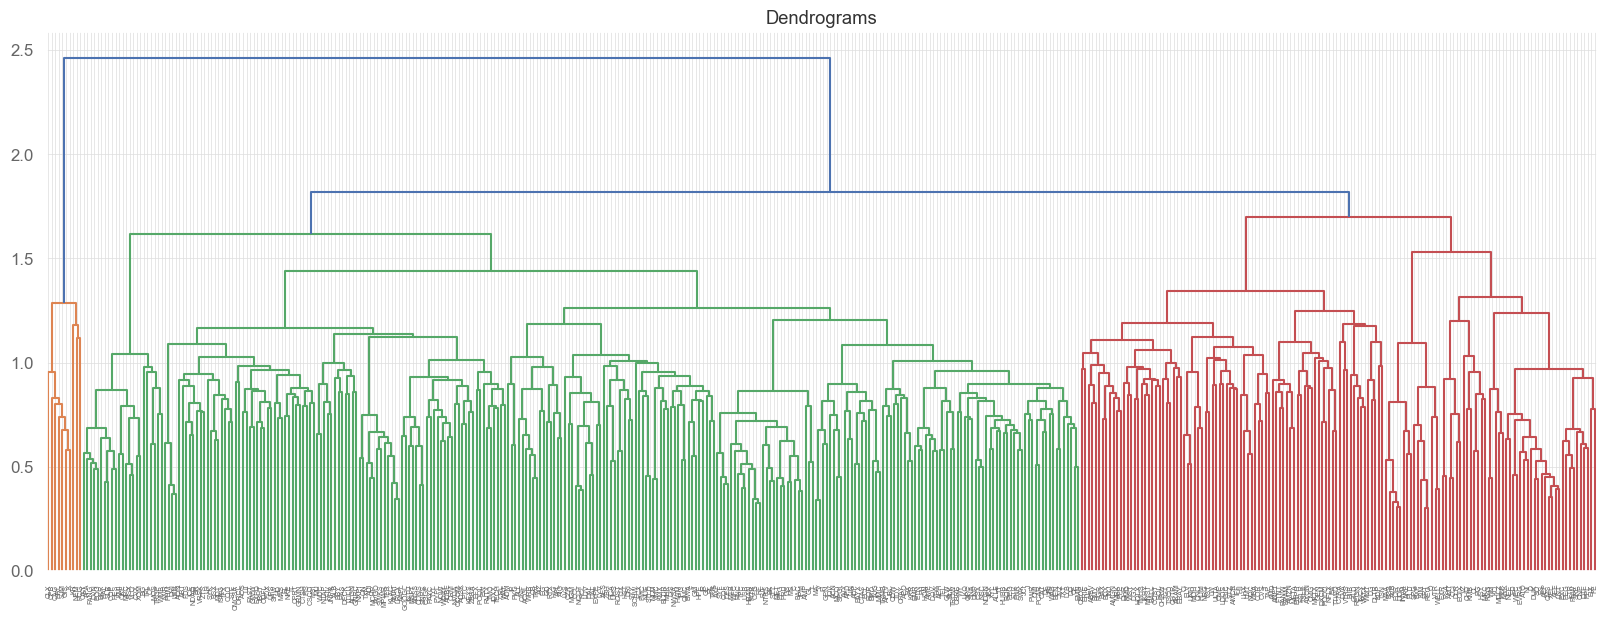

In [ ]:
plt.figure(figsize=(20, 7))
dendrogram(link, labels=df.columns, )
plt.title("Dendrograms")
# dendrogram(link, labels = df.columns)
plt.show()

In [177]:
threshold = 1.7  # Adjust based on dendrogram
# or use a fixed number of clusters
num_clusters = 5 

# Get cluster labels based on a distance threshold
clusters = fcluster(link, num_clusters, criterion='maxclust')  


In [206]:
final_dataframe = dataset[dataset["Ticker"].isin(returns.columns)]
final_dataframe["Sector"] = clusters
cluster_profile = final_dataframe.groupby("Sector").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = final_dataframe.groupby("Sector")["Ticker"].count().values
cluster_profile["Sharpe_ratio"] = (cluster_profile["Yavg_return"]-0.02)/cluster_profile["Yavg_volatility"]


max_cols = ["beta", "D_eSkewness", "Yavg_return", "Sharpe_ratio", "Davg_volume", "ROE", "ROA", "est_ROI", "profitMargins", "earningsGrowth"]
min_cols = ["beta", "Davg_span", "D_eCurtosis", "Yavg_volatility", "D_eVaR", "D_eCVaR", 
            "totalEsg", "environmentScore", "socialScore", "governanceScore"]

# Custom function for styling
def highlight_extremes(val, col_name):
    max_color = "background-color: green"
    min_color = "background-color: blue"
    
    if col_name in max_cols and val == cluster_profile[col_name].max():
        return max_color
    elif col_name in min_cols and val == cluster_profile[col_name].min():
        return min_color
    return ""

cluster_profile.style.apply(lambda x: [highlight_extremes(v, x.name) for v in x], axis=0)

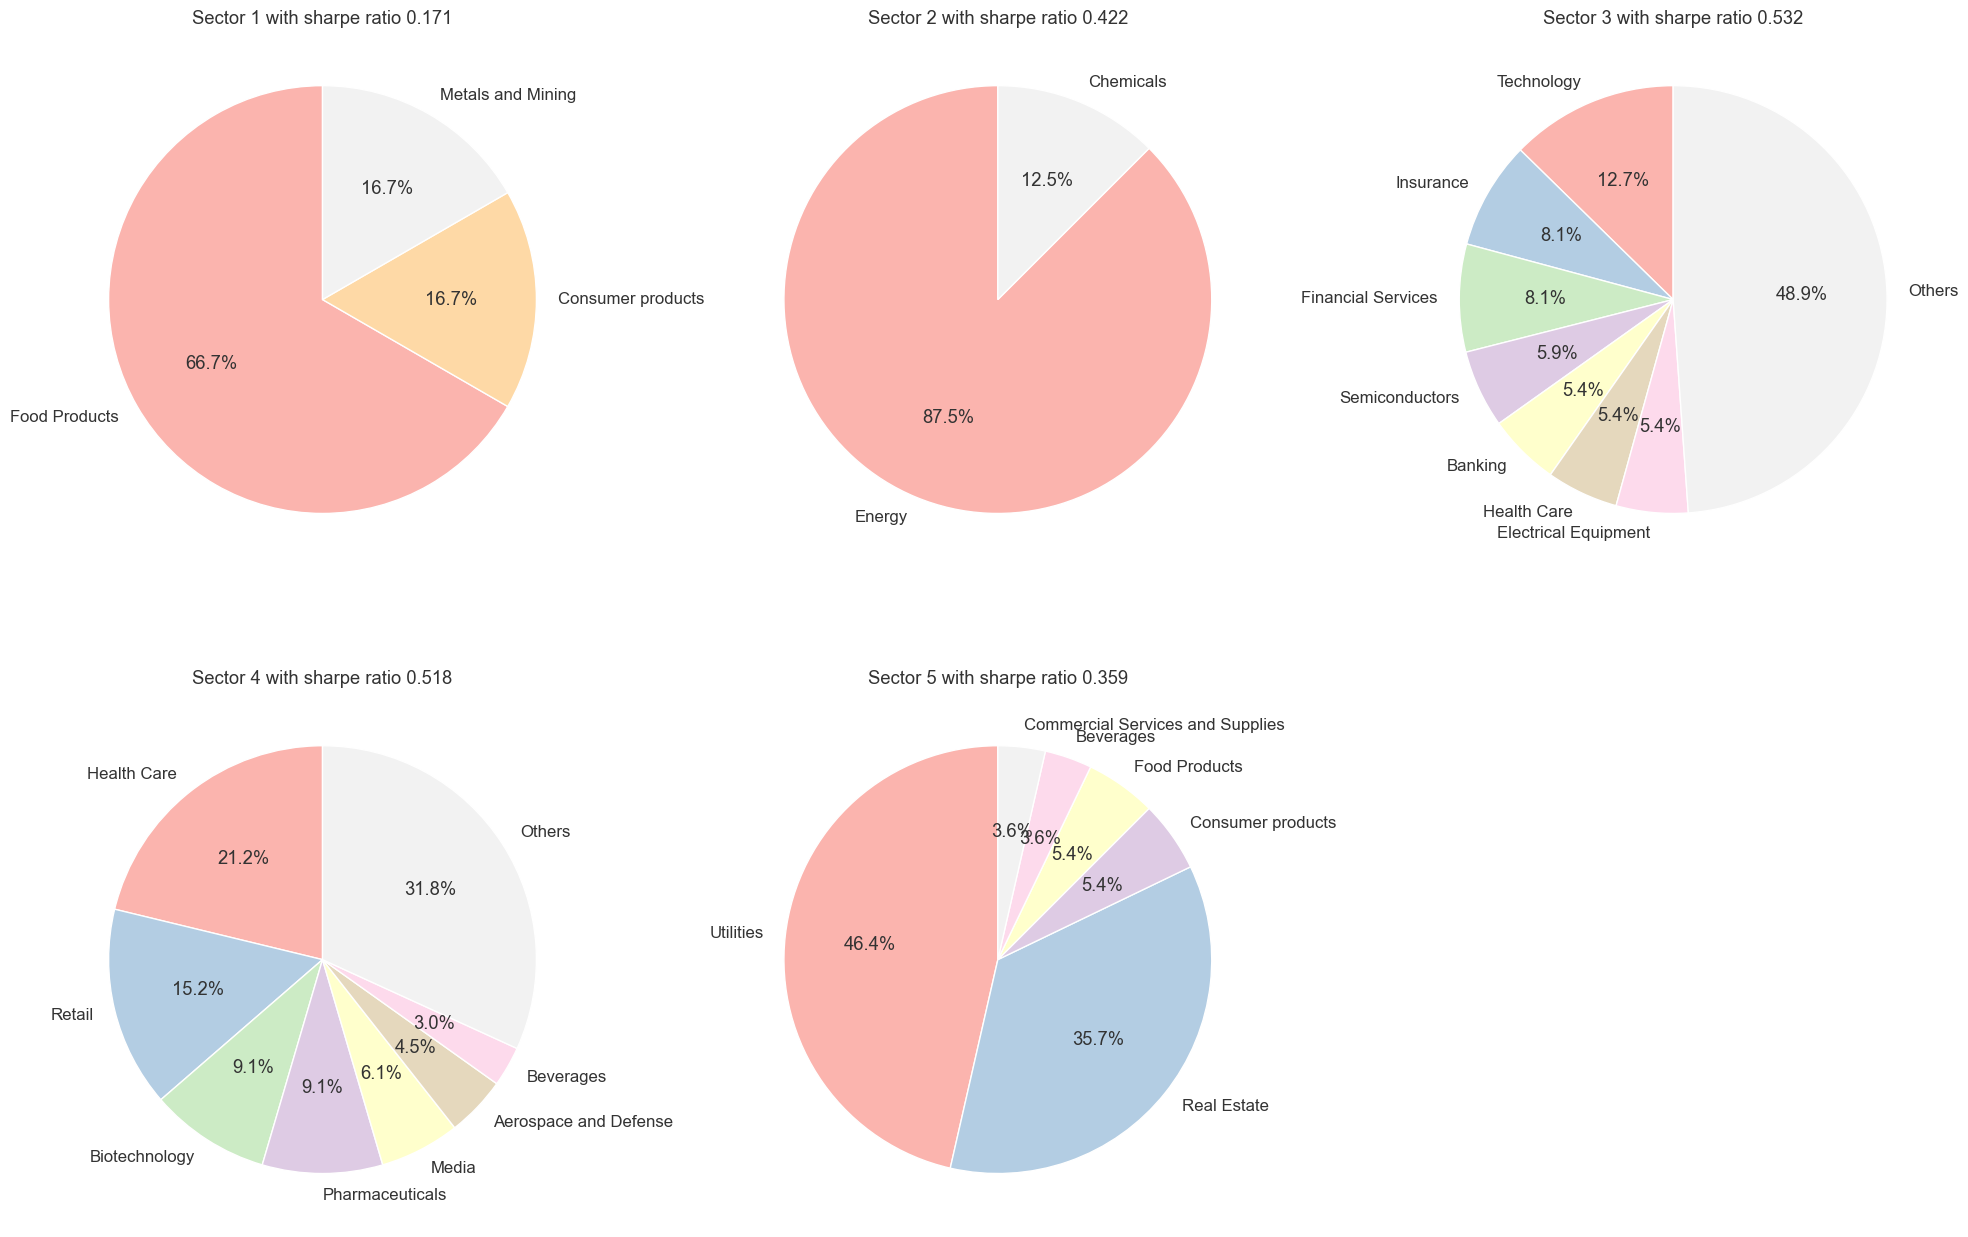

In [207]:
MAX_LABELS = 7
from analysis.data.plotting import plot_cluster_industry
plot_cluster_industry(MAX_LABELS, final_dataframe, cluster_profile.reset_index())

In [203]:
from analysis.data.dataframe_creation import create_portfolio_clustered
portfolio_ret, asset_ret = create_portfolio_clustered(sd, ed, final_dataframe, list(final_dataframe["Ticker"]), w="uniform")

[*********************100%***********************]  438 of 438 completed


Null values: False
Null values: False
Cluster Portfolios uniformly built among assets


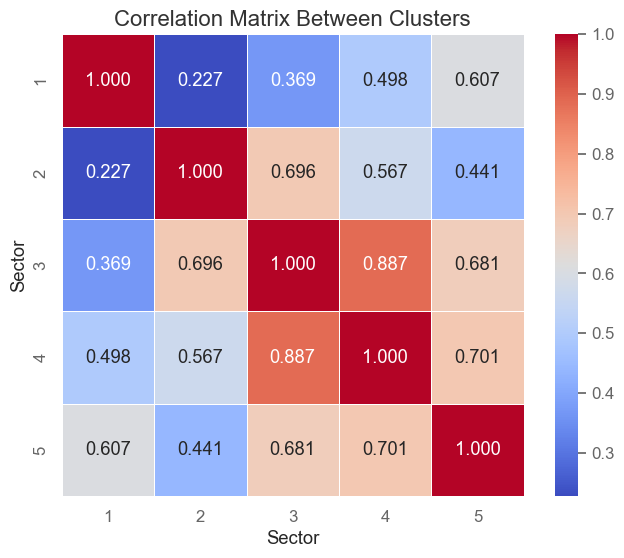

In [205]:
cor_matrix = portfolio_ret.corr()

# 2. Create a heatmap using seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(
    cor_matrix, 
    annot=True,  # Annotate the heatmap with the covariance values
    fmt=".3f",   # Format for the numbers
    cmap="coolwarm",  # Colormap for the heatmap
    linewidths=0.5,   # Add grid lines
    square=True       # Make the heatmap square
)

# 3. Add a title
plt.title("Correlation Matrix Between Clusters", fontsize=16)
plt.show()

In [204]:
R = returns_test.corr().reset_index()
# Initialize lists to store intra and inter-cluster correlation values
intra_cluster_corrs = []
inter_cluster_corrs = []

# Get the stock tickers (assuming they are in the column names)
stocks = asset_ret.columns

filtered_R = R[R["Ticker"].isin(asset_ret.columns)]

# Drop columns from R that are not in asset_ret columns
columns_to_drop = [col for col in filtered_R.columns if col not in asset_ret.columns]
cleaned_R = filtered_R.drop(columns=columns_to_drop)


# Loop through each pair of stocks
for i in range(len(stocks)):
    for j in range(i + 1, len(stocks)):  
        cluster_i = list(final_dataframe["Sector"])[i]
        cluster_j = list(final_dataframe["Sector"])[j]

        # Get the correlation for the pair of stocks
        correlation = R.iloc[i, j]

        # Check if stocks are in the same cluster (intra-cluster) or different clusters (inter-cluster)
        if cluster_i == cluster_j:
            intra_cluster_corrs.append(correlation)
        else:
            inter_cluster_corrs.append(correlation)

# Calculate average intra-cluster and inter-cluster correlation
avg_intra_cluster_corr = np.mean(intra_cluster_corrs)
avg_inter_cluster_corr = np.mean(inter_cluster_corrs)

print(f"Average intra-cluster correlation: {avg_intra_cluster_corr:.4f}")
print(f"Average inter-cluster correlation: {avg_inter_cluster_corr:.4f}")

# Compare
if avg_intra_cluster_corr < avg_inter_cluster_corr:
    print("Clusters are not well-separated (high intra-cluster correlation).")
else:
    print("Clusters are well-separated (low inter-cluster correlation).")

Average intra-cluster correlation: 0.2175
Average inter-cluster correlation: 0.1800
Clusters are well-separated (low inter-cluster correlation).


In [182]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        
        # Use pd.concat instead of append
        sortIx = pd.concat([sortIx, df0])  # item 2
        
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index

    return sortIx.tolist()

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w


def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'average')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [184]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [185]:
portfolios = get_all_portfolios(returns.reset_index())

Text(0.5, 1.0, 'HRP')

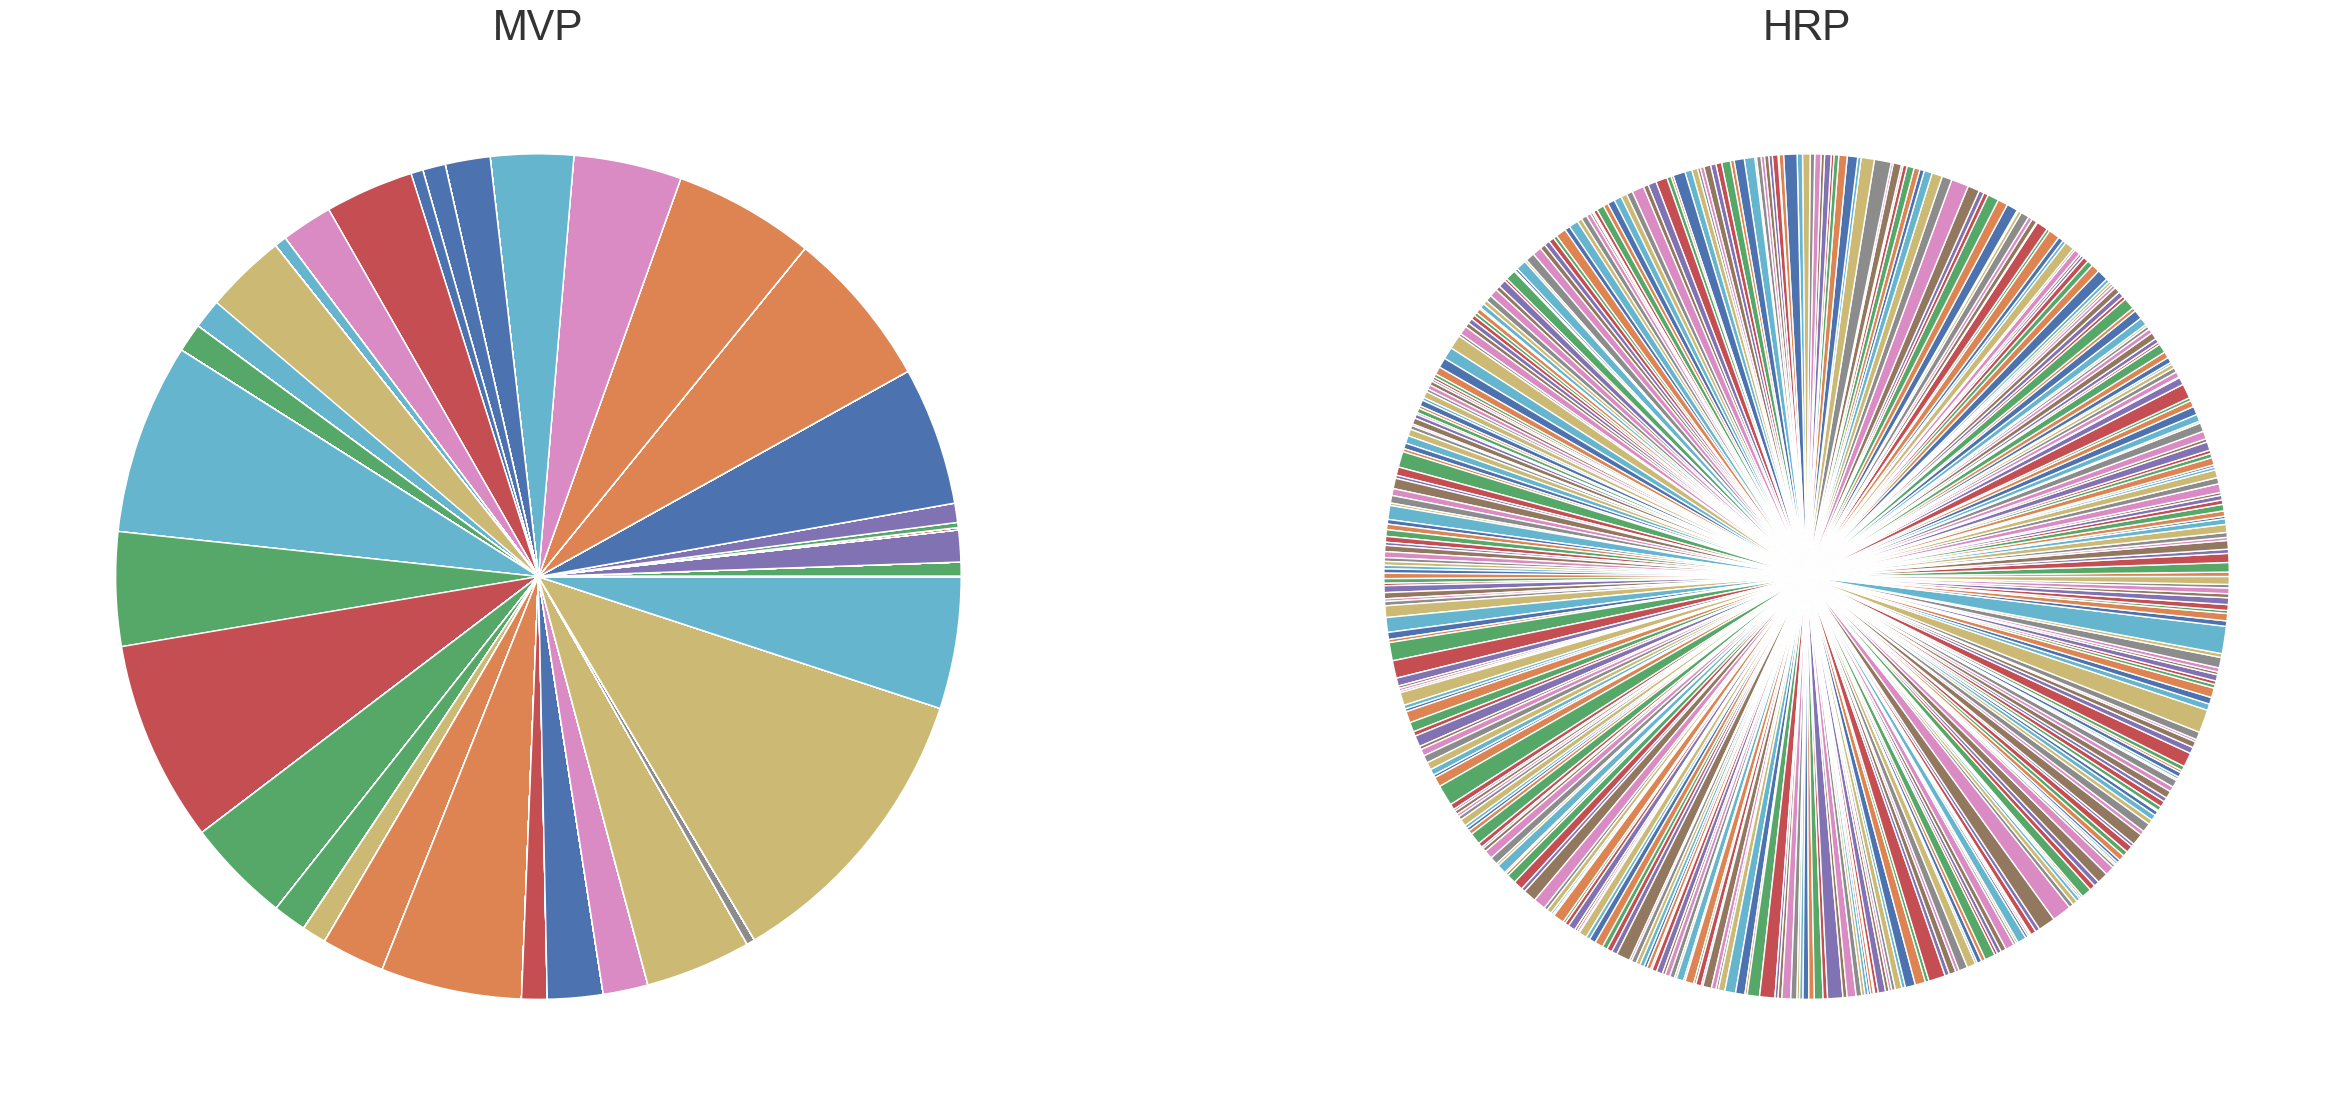

In [187]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], );
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1]);
ax2.set_title('HRP',fontsize = 30)

In [200]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios[1:])), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios[1:])), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<Axes: title={'center': 'Out Of Sample Results'}, xlabel='Date'>

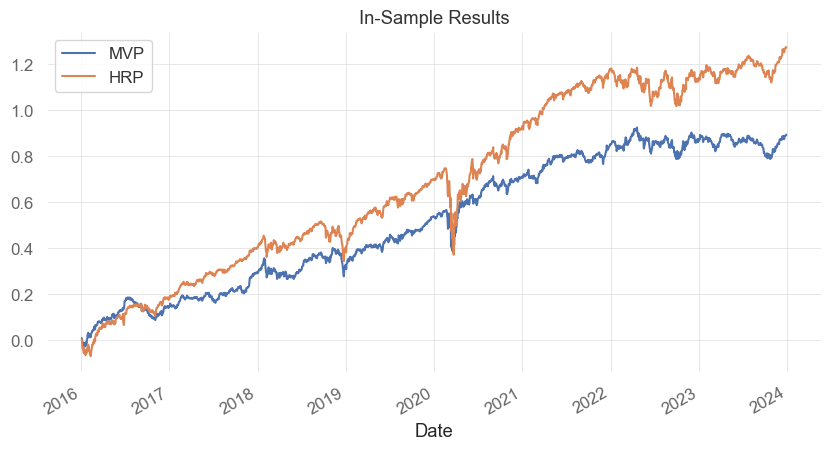

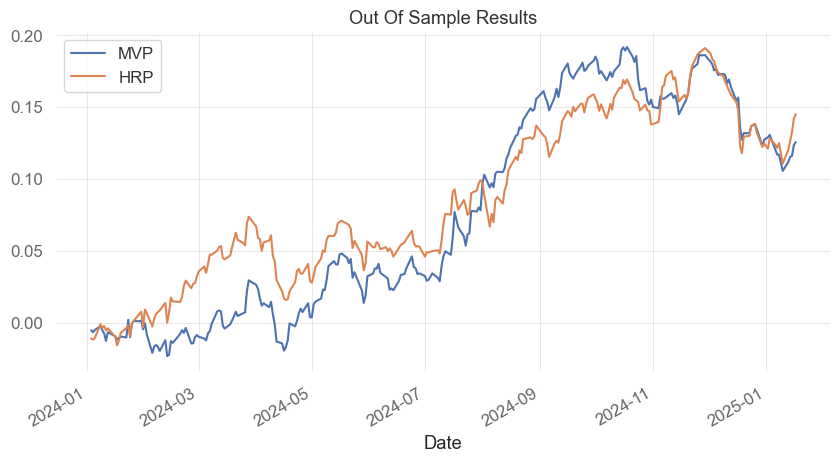

In [201]:
Insample_Result.cumsum().plot(figsize=(10, 5), title ="In-Sample Results")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), title ="Out Of Sample Results")

[*********************100%***********************]  1 of 1 completed


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2024-01-03  2024-01-03
End Period                 2025-01-17  2025-01-17
Risk-Free Rate             2.0%        2.0%
Time in Market             100.0%      100.0%

Cumulative Return          14.98%      28.05%
CAGR﹪                     14.35%      26.81%

Sharpe                     1.2         1.78
Prob. Sharpe Ratio         85.93%      94.52%
Smart Sharpe               1.11        1.65
Sortino                    1.71        2.58
Smart Sortino              1.59        2.39
Sortino/√2                 1.21        1.83
Smart Sortino/√2           1.12        1.69
Omega                      1.21        1.21

Max Drawdown               -7.78%      -8.41%
Longest DD Days            102         64
Volatility (ann.)          9.99%       12.68%
R^2                        0.54        0.54
Information Ratio          -0.08       -0.08
Calmar                     1.84        

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2024-12-02  2025-01-10  2025-01-17    46     -7.777891         -7.077267
2  2024-04-01  2024-04-17  2024-07-12   102     -5.653057         -5.601507
3  2024-08-01  2024-08-05  2024-08-15    14     -3.201811         -2.908996
4  2024-10-21  2024-10-31  2024-11-08    18     -3.082363         -3.068593
5  2024-09-03  2024-09-06  2024-09-13    10     -2.156660         -1.331931

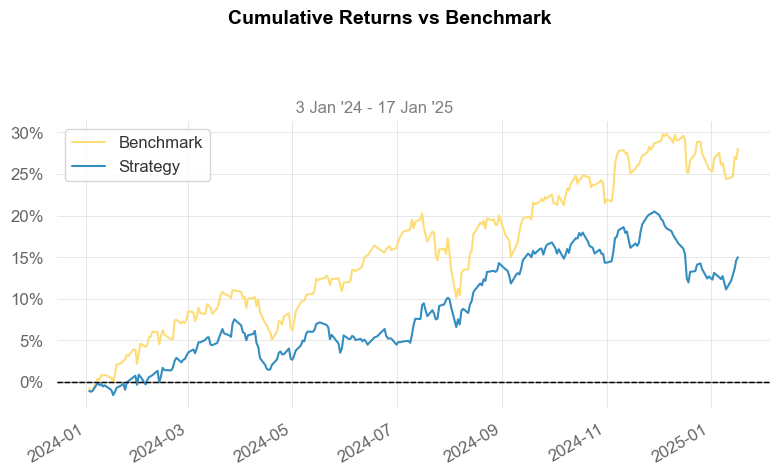

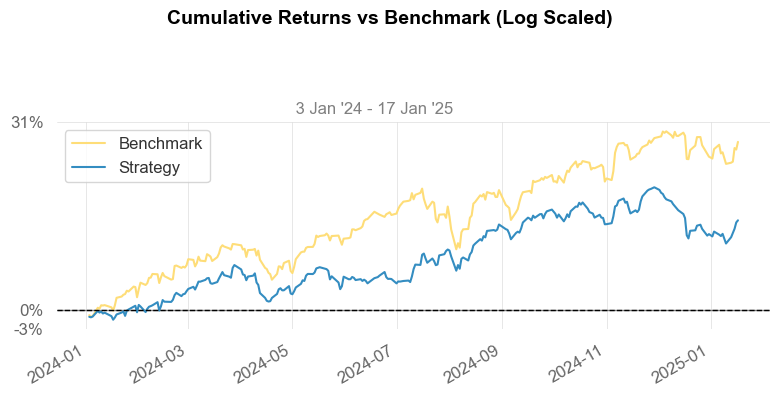

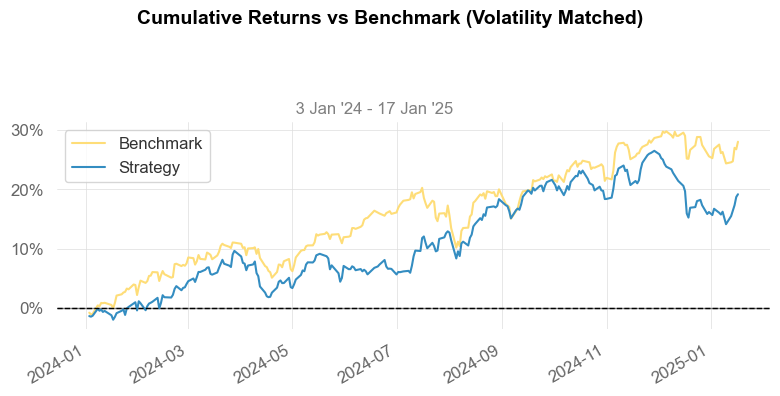

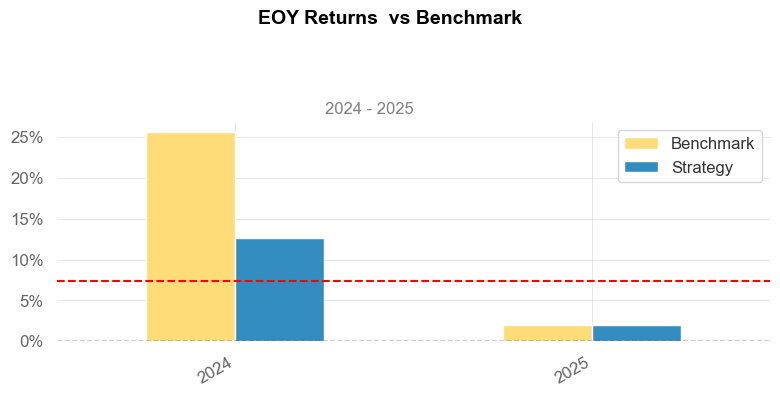

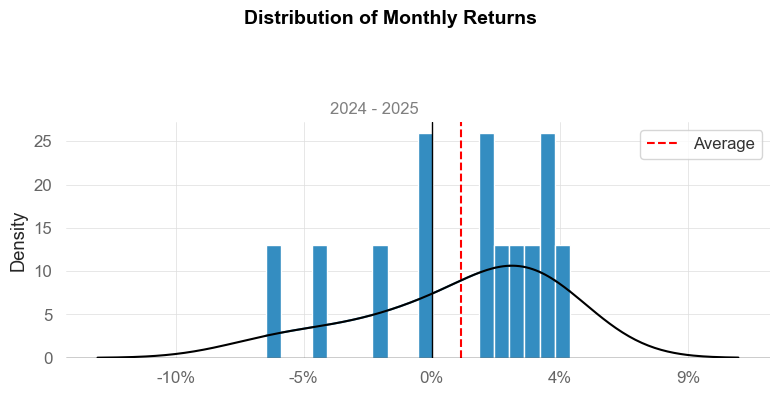

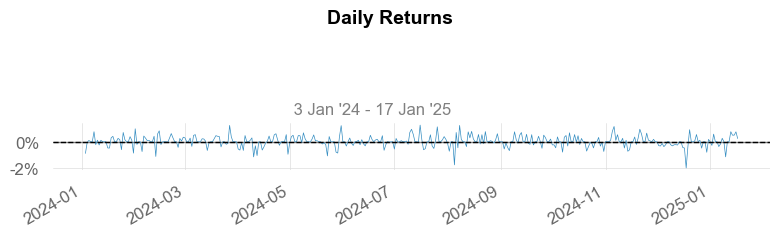

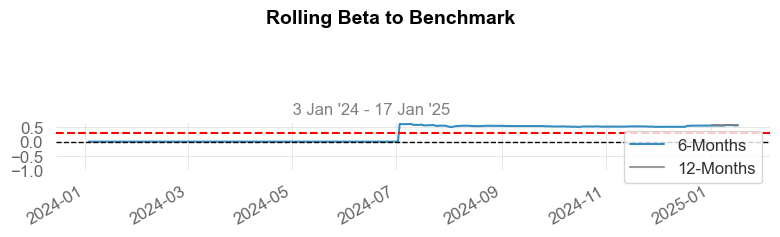

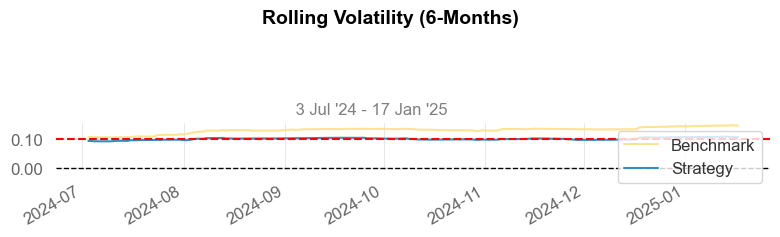

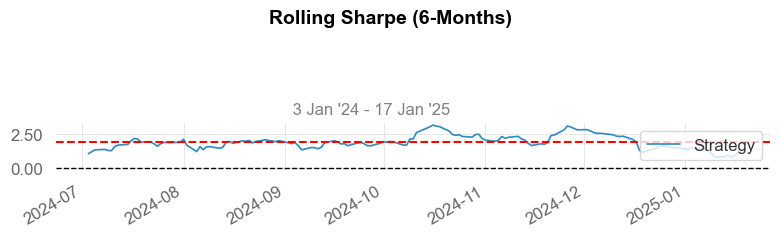

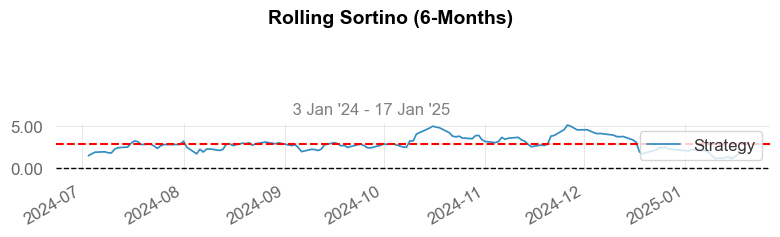

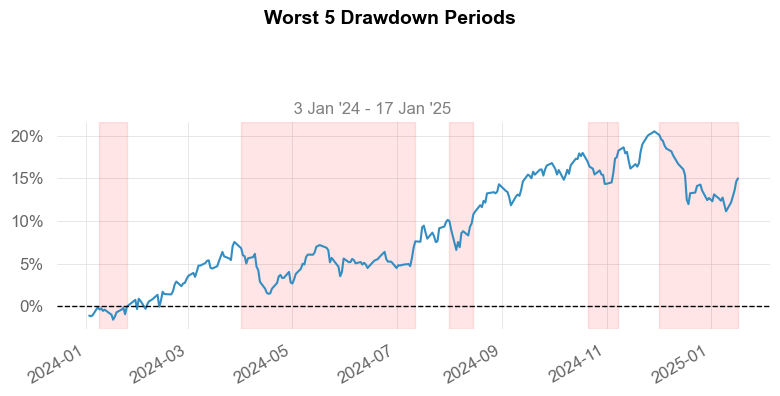

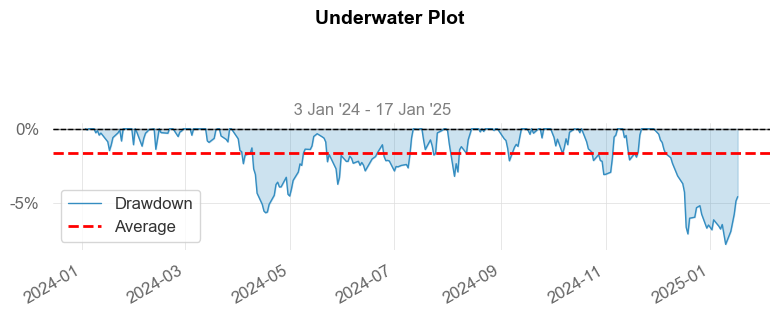

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

In [202]:
import quantstats as qs
benchmark_t = yf.download(tickers="SPY", start=sd_test, end=ed_test, auto_adjust=True)["Close"]
qs.reports.full(OutOfSample_Result["HRP"], benchmark=benchmark_t.pct_change().dropna(), rf=0.02)

In [108]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

stdev  sharp_ratio
MVP  0.121181     1.023355
HRP  0.162829     0.976281

In [109]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

stdev_oos  sharp_ratio_oos
MVP   0.095963         0.803973
HRP   0.110145         3.801951

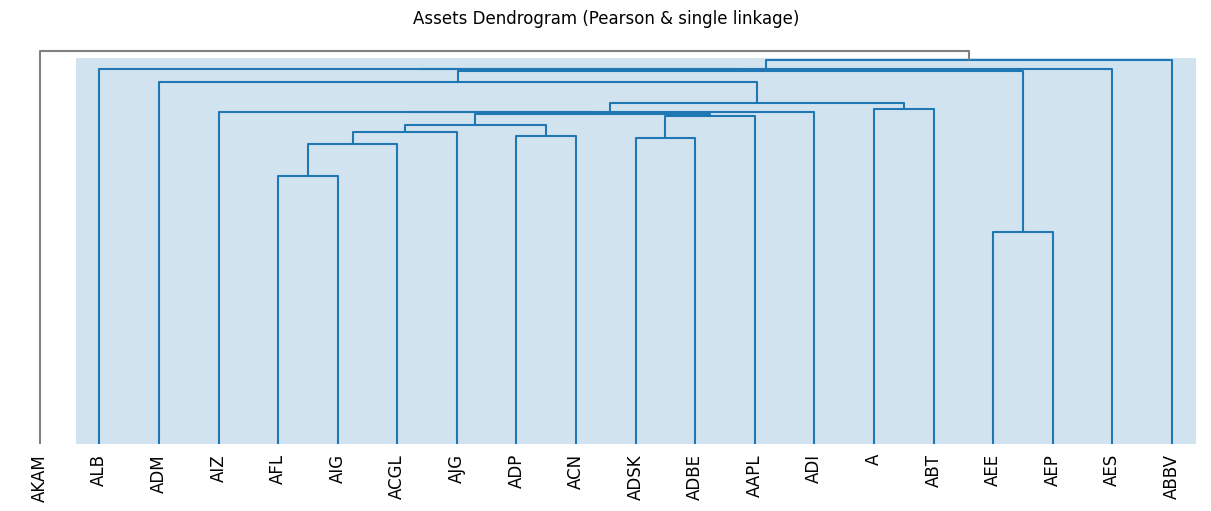

In [13]:
import riskfolio as rp

ax = rp.plot_dendrogram(returns=Y.drop(columns=Y.columns[20:]),
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)

In [ ]:
port = rp.HCPortfolio(returns=Y)

# Estimate optimal portfolio:

model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

display(w.T)

A      AAPL      ABBV       ABT      ACGL       ACN      ADBE  \
weights  0.002035  0.001745  0.003528  0.003102  0.001777  0.002551  0.002024   

              ADI       ADM       ADP  ...       WTW        WY      WYNN  \
weights  0.001251  0.004403  0.002094  ...  0.002509  0.001436  0.000893   

              XEL       XOM       XYL       YUM       ZBH      ZBRA       ZTS  
weights  0.002023  0.001421  0.001345  0.002919  0.002166  0.001017  0.002931  

[1 rows x 480 columns]

In [24]:
w_ret = np.concatenate(np.array(w.iloc[:10], w.iloc[10:].sum()))
w_ret

array([0.0020355 , 0.0017453 , 0.00352782, 0.00310194, 0.00177729,
       0.00255065, 0.00202352, 0.00125102, 0.00440303, 0.00209403])

In [56]:
w = w.sort_values(by="weights", ascending=False)
w_ret = w[:100]
others = pd.Series({"Others": float(w[100:].sum())})
others = others.rename("weights")

# Concatenate w_ret with the new "Others" row
w_ret = pd.concat([w_ret, others])
w_ret

weights
WM      0.007991
JNJ     0.006670
VZ      0.006298
MRK     0.006098
HRL     0.006077
...          ...
YUM     0.002919
AIZ     0.002916
FFIV    0.002907
WST     0.002904
Others  0.603744

[101 rows x 1 columns]

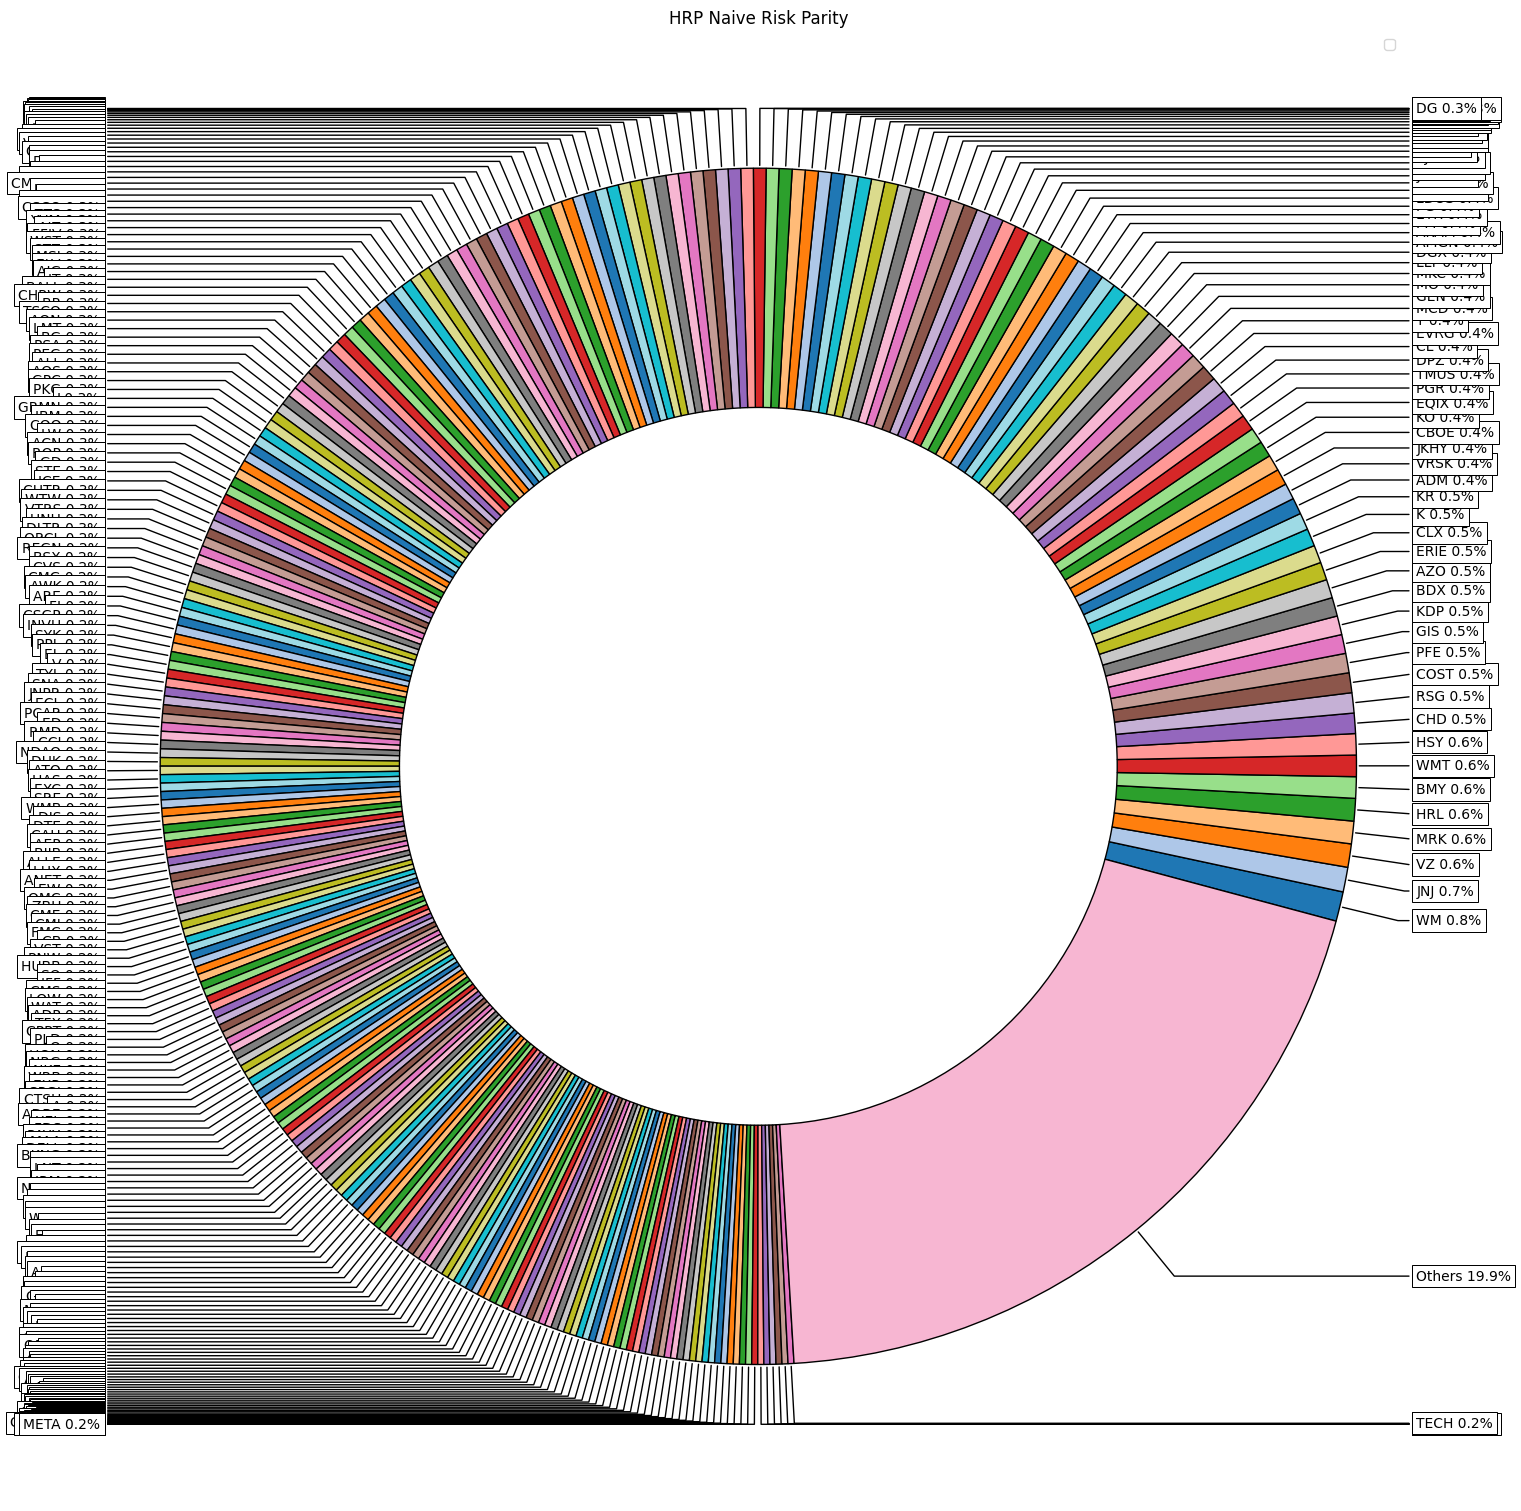

In [64]:
ax = rp.plot_pie(w=w,
                 title='HRP Naive Risk Parity',
                 others=0.2, 
                 cmap="tab20",
                 height=15,
                 width=15,
                 ax=None,
                 nrow=15)
ax.legend()

